In [1]:
%matplotlib notebook

import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from darkflow.net.build import TFNet
import track.sort.sort as srt

In [2]:
# directory with images from video
#working_directory = '/home/analyticsuser/data/Husband Surprises Wife by Filling House With Puppies!'
working_directory = '/home/analyticsuser/data/Nest Cam - Owner catches burglars in act on her phone'

# only images
files_in_directory = sorted([os.path.join(working_directory, file_name)
                      for file_name in os.listdir(working_directory)
                      if os.path.splitext(file_name)[1].lower() in ('.jpg', '.jpeg')])

# colors for different bboxes for visualization
colors = [(255,0,0), (0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(192,192,192),(128,128,128),
          (128,0,0),(128,128,0),(0,128,0),(128,0,128),(0,128,128),(0,0,128),(0,0,0)]

# configuration for YOLO
options = {'model': '/home/analyticsuser/darkflow/cfg/yolo.2.0.cfg', 
           'load': '/home/analyticsuser/darkflow/cfg/yolo.2.0.weights', 'threshold': 0.1}

# options = {'model': '/home/analyticsuser/darkflow/cfg/yolo-voc.2.0.cfg', 
#            'load': '/home/analyticsuser/darkflow/cfg/yolo-voc.2.0.weights', 'threshold': 0.1}

tfnet = TFNet(options)

# initialize SORT tracker:
# - 10 consecutive frames with no detection to terminate an existing track
# - 1 consecutive frame (i.e. after an initial frame) to activate the new track (before that will not produce any output)
# - 5 frames to extrapolate an active track (i.e. show predicted output eventhough no detection present for this track)
# - 0.8 unassigned detection over track bbox overlap (intersection over union) threshold to eliminate the detection
# - 0.94 unassigned detection over another stronger unassigned detection overlap (intersection over self bbox area) threshold to eliminate the detection
# - 0.8 unassigned detection over another stronger unassigned detection overlap (intersection over larger bbox area) threshold to eliminate the detection
# - 2.0 defines "stronger" detection disregarding the size -- if the score of the unassigned detection overlapping 
#       another unassigned detection is 2.0-times higher than the score of the other detection, it is stronger, otherwise 
#       larger size decides
mot_tracker = srt.Sort(10,0,10,0.55,0.90,0.6,2.0)

Parsing ./cfg/yolo.2.0.cfg
Parsing /home/analyticsuser/darkflow/cfg/yolo.2.0.cfg
Loading /home/analyticsuser/darkflow/cfg/yolo.2.0.weights ...
Successfully identified 269862452 bytes
Finished in 0.029219388961791992s


<VideoCapture 0x7fc3d86c3610>


<IPython.core.display.Javascript object>


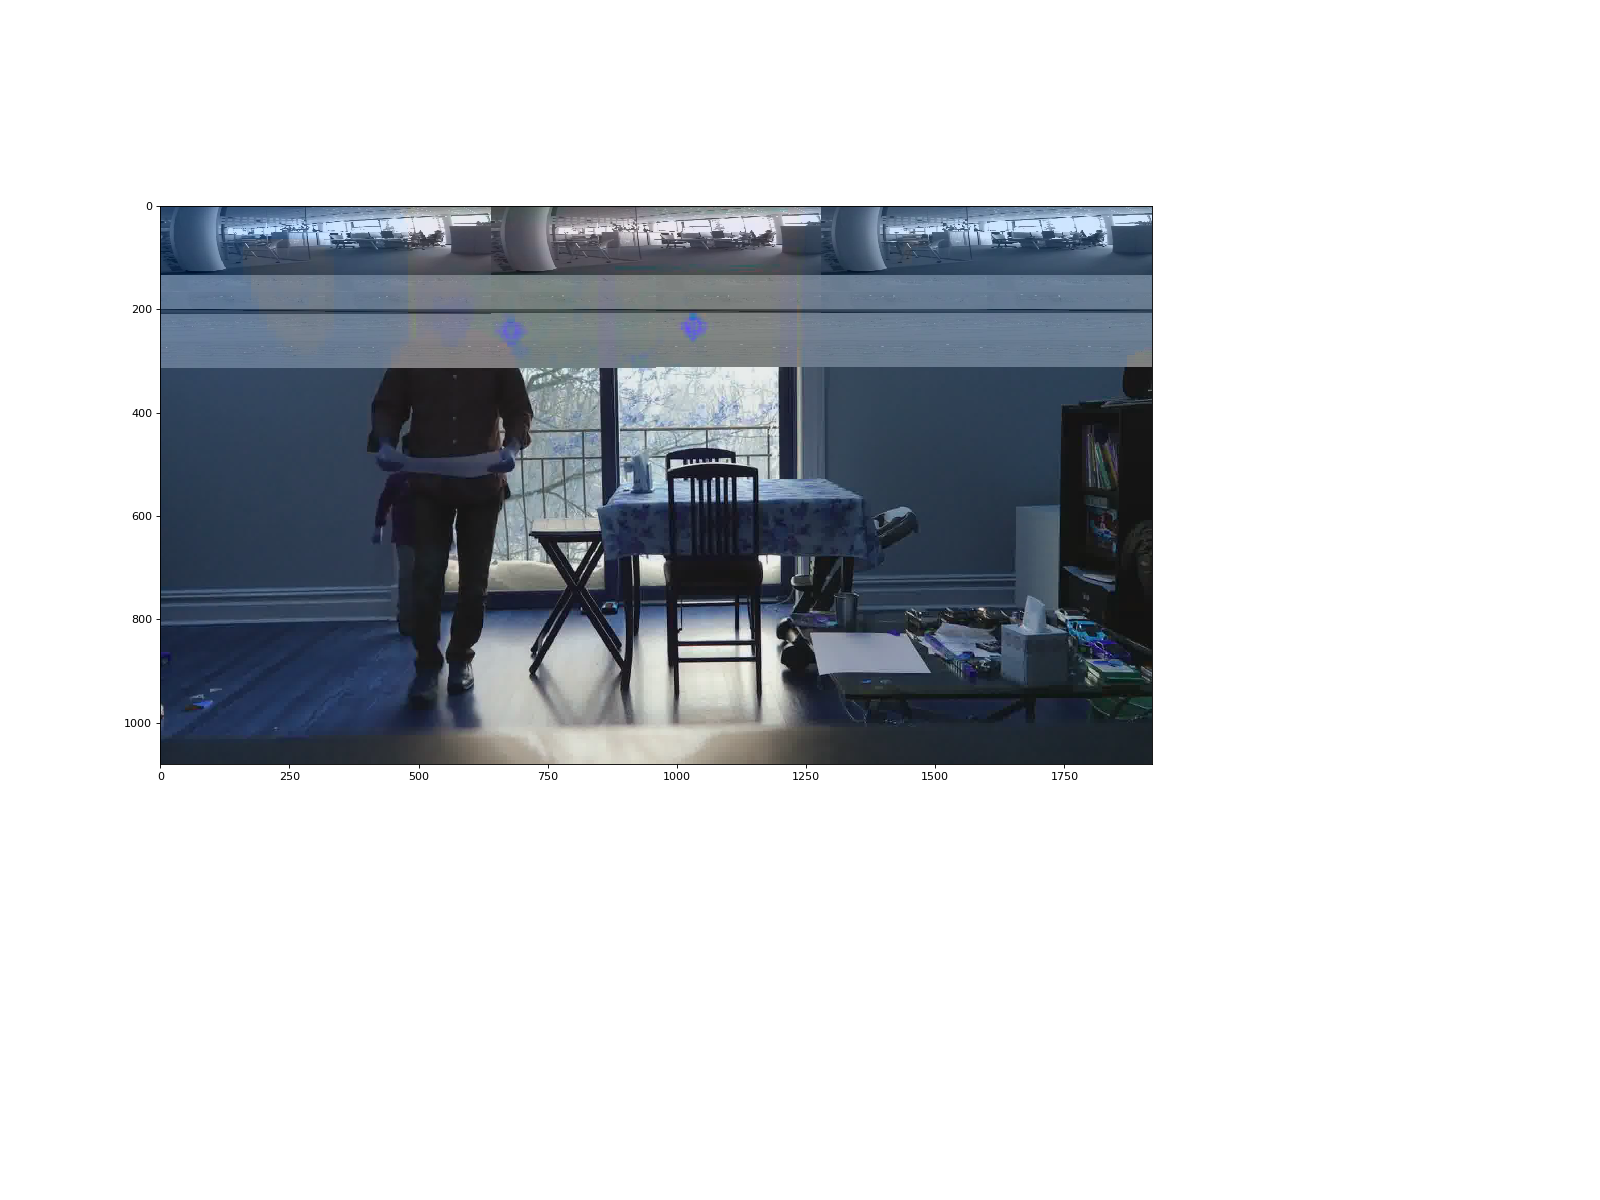

/home/analyticsuser/anaconda3/envs/jupyter/lib/python3.6/site-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


KeyboardInterrupt: 

In [3]:
plt.ion()

# init Camrea reader & matplotlib displaying
cap = cv2.VideoCapture(0)
print(cap)
ret, imgcv = cap.read()

imgcv_to_display = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
# pltimage = np.concatenate((imgcv_to_display, imgcv_to_display), axis=1)
fig=plt.figure(figsize=(16,12), dpi= 80, facecolor='w', edgecolor='k')
# detections_preview = plt.imshow(pltimage)
detections_preview = plt.imshow(imgcv)
try:
    plt.pause(0.05)
except Exception:
    pass

# displaying all
# allres = []
while(True):
    ret, imgcv = cap.read()
    if type(imgcv) == type(None):
        print("!!! Couldn't read frame!")
        break    

    img1 = imgcv.copy()
    result = tfnet.return_predict(imgcv)
    for idx, detection in enumerate(result):
        if detection['label'] == 'person' or detection['label'] == 'dog' or detection['label'] == 'cat':
            cv2.rectangle(imgcv, (detection['topleft']['x'], detection['topleft']['y']), 
                          (detection['bottomright']['x'], detection['bottomright']['y']), 
                          colors[idx % len(colors)], 10)

            cv2.rectangle(imgcv, (detection['topleft']['x'], detection['topleft']['y'] - 20), 
                          (detection['bottomright']['x'], detection['topleft']['y']), (125, 125, 125), -1)

            cv2.putText(imgcv, detection['label'] + ' : %.2f' % detection['confidence'], 
                        (detection['topleft']['x'] + 5, detection['topleft']['y'] - 7), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
       
    
    # continue with tracking
    # print('result: ', result) 
    fres = list(filter(lambda x: x['label'] == 'person' or x['label'] == 'dog' or x['label'] == 'cat',result))
    dets0 = list(map( lambda x: [float(x['topleft']['x']),float(x['topleft']['y']),
                                 float(x['bottomright']['x']),float(x['bottomright']['y']),
                                 x['confidence']], fres))
    # print('dets0: ', dets0) 
    # allres += [','.join(list(map(lambda x: str(x),dets0)))]   # save the results
    dets = np.asarray( dets0 )
    objs,termtracks = mot_tracker.update(dets)
    # print('objs: ', objs) 
    for bbo_f in objs:
        # print('bbo_f: ', bbo_f )
        bbo = list(map(lambda x: int(round(float(x))), bbo_f[0:4]))
        obid = int(bbo_f[5])
        obsc = bbo_f[4]
        cv2.rectangle(img1, (bbo[0], bbo[1]), (bbo[2], bbo[3]), colors[obid%len(colors)], 10)
        cv2.rectangle(img1, (bbo[0], bbo[1]-40), (bbo[2], bbo[1]), (125, 125, 125), -1)
        cv2.putText(img1, 'id=%03d'%obid + ' @%0.2f'%obsc, (bbo[0]+5, bbo[1]-7), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

    imgcv_to_display = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
    
    imgcv_to_display2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            
#     pltimage = np.concatenate((imgcv_to_display, imgcv_to_display2), axis=1)
#     detections_preview.set_data(pltimage)
    detections_preview.set_data(imgcv_to_display)

    plt.draw()
    try:
        plt.pause(0.0002)
    except Exception:
        pass

#content = '\n'.join(allres)
#with open('yolodet.txt', 'w') as fro:
#    fro.write(content)
